In [1]:
from pytfa.io.json import load_json_model
from cobra import Reaction

# New model with changed nadh 
redgem_file_name = 'reduced_model_ETC_core_20250228-213124.json'

reduced_model = load_json_model(redgem_file_name)
reduced_model.optimize()

# remove sinks if there are still any
reduced_model.remove_reactions([rxn.id for rxn in reduced_model.reactions if 'sink' in rxn.id])

# Thermo for sodium
reduced_model.thermo_data['metabolites']['cpd00971']['deltaGf_std'] = 1.0
reduced_model.thermo_data['metabolites']['cpd00971']['deltaGf_err'] = 0.1
reduced_model.thermo_data['metabolites']['cpd00971']['error']  = 'Nil'


2025-09-11 11:23:17,195 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Resting membrane potential
reduced_model.compartments['c']['membranePot']['e'] = 60
reduced_model.compartments['e']['membranePot']['c'] = -60
# Resting mitochondrial membrane potential
reduced_model.compartments['m']['membranePot']['c'] = 150
reduced_model.compartments['c']['membranePot']['m'] = -150


In [3]:
reduced_model.compartments['m']['pH'], reduced_model.compartments['c']['pH']

(8.0, 7.2)

In [4]:
# Change h_i to h_c

for reactions in reduced_model.metabolites.h_i.reactions:
    h_i_stoichiometry = reactions.metabolites[reduced_model.metabolites.h_i]
    reactions.add_metabolites({reduced_model.metabolites.h_c: h_i_stoichiometry})
    reactions.add_metabolites({reduced_model.metabolites.h_i: -h_i_stoichiometry})

In [5]:


# Produces 2 mitochondrial protons -> seems wrong! 
# Assume this is not working
reduced_model.reactions.L_LACDcm.bounds = (0.0, 0.0)


In [6]:
# PROTON LEAK other processes that transport protons in an out
# To remove mito H+ moiety
proton_in = Reaction('proton_in')
reduced_model.add_reactions([ proton_in,])
proton_in.reaction = 'h_c -> h_m'

reduced_model.reactions.proton_in.bounds = (1.0, 1.1)

# proton_out = Reaction('proton_out')
# reduced_model.add_reactions([ proton_out,])
# proton_out.reaction = 'h_m -> h_c'

In [7]:
# AMP Hydrolysis by other proceses
atp2amp_c = Reaction('atp2amp_c')
reduced_model.add_reactions([ atp2amp_c,])
atp2amp_c.reaction = 'atp_c + h2o_c -> amp_c + ppi_c + h_c'

In [8]:
# Remove constraints of type ModelConstraints 
from tqdm import tqdm

cons_subclass = reduced_model._cons_kinds['ModelConstraint']
for cons in tqdm(cons_subclass):
    reduced_model.remove_constraint(cons)


reduced_model.repair()

#### Prepare and convert model
reduced_model.prepare()
reduced_model.convert()

100%|██████████| 5/5 [00:00<00:00, 3308.33it/s]
2025-09-11 11:23:17,484 - thermomodel_Recon3thermoCurated - INFO - # Model preparation starting...
2025-09-11 11:23:17,494 - thermomodel_Recon3thermoCurated - INFO - # Model preparation done.
2025-09-11 11:23:17,495 - thermomodel_Recon3thermoCurated - INFO - # Model conversion starting...
2025-09-11 11:23:17,657 - thermomodel_Recon3thermoCurated - INFO - # Model conversion done.
2025-09-11 11:23:17,658 - thermomodel_Recon3thermoCurated - INFO - # Updating cobra_model variables...
2025-09-11 11:23:17,660 - thermomodel_Recon3thermoCurated - INFO - # cobra_model variables are up-to-date


In [9]:
# Proton corrections for FAD reactions 
reduced_model.reactions.FADH2ETC.add_metabolites({reduced_model.metabolites.h_m: -1.0})
reduced_model.reactions.FAOXC160.add_metabolites({reduced_model.metabolites.h_m: 7.0})

In [10]:
# Balance this reaction correctly the extra proton should appear in mitochondria not be transported to the cytoplasm
reduced_model.reactions.NADH2_u10mi.add_metabolites({reduced_model.metabolites.h_c: -1})
reduced_model.reactions.NADH2_u10mi.add_metabolites({reduced_model.metabolites.h_m: 1})

In [11]:
# ATP synthase should transport 3 proton from the intermembrane space to the instead of 4 
reduced_model.reactions.ATPS4mi.add_metabolites({reduced_model.metabolites.h_c: 1})
reduced_model.reactions.ATPS4mi.add_metabolites({reduced_model.metabolites.h_m: -1})

# These protons are part of the PiC transport
reduced_model.reactions.PiC.add_metabolites({reduced_model.metabolites.h_c: -1})
reduced_model.reactions.PiC.add_metabolites({reduced_model.metabolites.h_m: 1})

In [12]:
# Refine Glycolysis corrected delta G constraints from Lehninger:
# Units are in kJ/mol
glycolysis_thermodynamics = {
    'HEX1': -16.7,
    'PGI': 1.7,
    'PFK': -14.9,
    'FBA': 23.8,
    'TPI': 5.6, # Equilibrator value
    'GAPD': 6.3,
    'PGK': 18.8,
    'PGM': 4.4, 
    'ENO': 7.5,
    'PYK': -31.4,
    'LDH_L': 25.5, # Equilibrator value
    'LDH_Lm': 20.8, # Equilibrator value
    }

# Converstion to kcal/mol
scaling = 0.239006
for r_id, dg in glycolysis_thermodynamics.items():
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    try:
        dgo.ub = dg * scaling + 0.1
        dgo.lb = dg * scaling - 0.1
    except ValueError:
        dgo.lb = dg * scaling - 0.1
        dgo.ub = dg * scaling + 0.1

    reduced_model.optimize()
    print(f"{r_id} : {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")


sol = reduced_model.optimize()

HEX1 : -4.0914002 < -3.8914001999999996 < -3.8914001999999996 kcal/mol
PGI : 0.3063102 < 0.3063102 < 0.5063102 kcal/mol
PFK : -3.6611894 < -3.6611894 < -3.4611894 kcal/mol
FBA : 5.5883428 < 5.5883428 < 5.7883428 kcal/mol
TPI : 1.2384335999999998 < 1.2384335999999998 < 1.4384336 kcal/mol
GAPD : 1.4057377999999998 < 1.4057377999999998 < 1.6057378 kcal/mol
PGK : 4.3933128 < 4.5933128 < 4.5933128 kcal/mol
PGM : 0.9516264 < 1.1516264 < 1.1516264 kcal/mol
ENO : 1.692545 < 1.692545 < 1.8925450000000001 kcal/mol
PYK : -7.6047883999999994 < -7.6047883999999994 < -7.4047884 kcal/mol
LDH_L : 5.9946530000000005 < 6.194653 < 6.194653 kcal/mol
LDH_Lm : 4.8713248 < 4.8713248 < 5.071324799999999 kcal/mol


In [13]:
reduced_model.reactions.L_LACtm.thermo

{'isTrans': True,
 'computed': True,
 'deltaGR': -1.0905609991066534,
 'deltaGrxn': 0,
 'deltaGRerr': 2}

In [14]:
# Manuall estimate of ATP synthase delta G'
import numpy as np
# Compute PMF 
# 150 mV 
R = 8.314
T = 310
F = 96485

proton_force = R * T * np.log(10) * 0.8 /1000 
pmf = (150 * F / 1000 + R * T * np.log(10) * 0.8) /1000 
atps_dgo = 30.5 - pmf * 3

In [15]:
# Refine TCA corrected delta G constraints from Lehninger:
# Units are in kJ/mol
tca_thermodynamics = {
    'PDHm' : -33.4,
    'CSm' : -32.3,
    'ACONTm' : 13.3,
    'ICDHxm' : 10.0, # Equilibrator value ?!?!
    'AKGDm' : -33.5,
    'SUCOAS1m' : -2.9,
    'r0509' : -24.1, # Equilibrator value (EC: 1.3.5.1) 
    'FUMm': -3.8,
    'MDHm' : 23,
    'MDH': 28.3 , # MDH delta proton correction in cytosol (nH 2.3 RT * delta pH)
    'ADK1': 0.3, # Equilibrator value ?!
    'NDPK1m': -2.7, # Equilibrator value  (EC: 2.7.4.6)
    'FADH2ETC': -70/2, # Equilibrator  value ?
    'G3PD1': 22.6, # Equilibrator value ?!?
    'r0205': -59.7, # Equilibrator value ?!?
    'PiC': -proton_force ,  
    'PPA': -19, # 
    'FACOAL160i': -15, # Lehninge
    'BDHm': 8.0, # Equilibrator value (EC: 1.1.1.30)
    'OCOAT1m': 12.6, # Equilibrator value (EC: 2.8.3.5)
    'ACACT1rm': 25, # Equilibrator value (EC: 2.3.1.9)
    'C160CPT1': -2.2, # Equilibrator value (EC: 2.3.1.21 reverse)
    'C160CPT1': 2.2, # Equilibrator value (EC: 2.3.1.21)
    'ATPS4mi': atps_dgo, # Equilibrator value (EC:
    'ATPtm': -14.47, # This is charged transport of ATP deltapsi 
    'ASPTA': 2.8, # Equilibrator value 
    'ASPTAm': 2.8, # Equilibrator value
}
# Converstion to kcal/mol
scaling = 0.239006
for r_id, dg in tca_thermodynamics.items():
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    try:
        dgo.ub = dg * scaling + 0.1
        dgo.lb = dg * scaling - 0.1
    except ValueError:
        dgo.lb = dg * scaling - 0.1
        dgo.ub = dg * scaling + 0.1

    reduced_model.optimize()
    print(f"{r_id} : {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")
    

sol = reduced_model.optimize()

PDHm : -8.0828004 < -8.0828004 < -7.8828004 kcal/mol
CSm : -7.819893799999999 < -7.819893799999999 < -7.6198938 kcal/mol
ACONTm : 3.0787798 < 3.0787798 < 3.2787798 kcal/mol
ICDHxm : 2.29006 < 2.29006 < 2.49006 kcal/mol
AKGDm : -8.106701 < -8.106701 < -7.906701 kcal/mol
SUCOAS1m : -0.7931174 < -0.5931174 < -0.5931174 kcal/mol
r0509 : -5.8600446 < -5.8600446 < -5.660044600000001 kcal/mol
FUMm : -1.0082228 < -1.0082228 < -0.8082228 kcal/mol
MDHm : 5.397138 < 5.397138 < 5.597137999999999 kcal/mol
MDH : 6.6638698000000005 < 6.6638698000000005 < 6.8638698 kcal/mol
ADK1 : -0.02829820000000001 < -0.02829820000000001 < 0.17170180000000002 kcal/mol
NDPK1m : -0.7453162 < -0.7453162 < -0.5453162 kcal/mol
FADH2ETC : -8.465209999999999 < -8.465209999999999 < -8.26521 kcal/mol
G3PD1 : 5.3015356 < 5.3015356 < 5.5015355999999995 kcal/mol
r0205 : -14.3686582 < -14.3686582 < -14.168658200000001 kcal/mol
PiC : -1.2347134254903602 < -1.2347134254903602 < -1.03471342549036 kcal/mol
PPA : -4.641114 < -4.6411

In [16]:
# Make sure that transporters dont have unrealistic equilibrium constants
EPSILON_DG = 1e-6

exceptions = ['ATPS4mi','CYOR_u10mi','CYOOm2i','NADH2_u10mi','PiC','ATPtm']
# Print transport deltaG0
for r in reduced_model.reactions:
    if r.thermo['isTrans'] and (r.id not in exceptions):
        try:
            print(f"{r.id} : {r.reaction} {r.thermo['deltaGR']} kcal/mol")
            dgo = reduced_model.delta_gstd.get_by_id(r.id)
            dgo.variable.ub = r.thermo['deltaGR'] + EPSILON_DG
            dgo.variable.lb = r.thermo['deltaGR'] - EPSILON_DG
        except KeyError:
            pass

# Limit the delta G error of Fatty-acid oxidation
reduced_model.delta_gstd.FAOXC160.variable.lb = -44 - 2
reduced_model.delta_gstd.FAOXC160.variable.ub = -44 + 2

reduced_model.delta_gstd.The.variable.ub = 1
reduced_model.delta_gstd.The.variable.lb = -1


reduced_model.optimize()



AKGMALtm : akg_m + mal_L_c <=> akg_c + mal_L_m 0.0012994733051527874 kcal/mol
ASPGLUm : asp_L_m + glu_L_c + h_c --> asp_L_c + glu_L_m + h_m -4.550942133284353 kcal/mol
BHBt : bhb_e + h_e <=> bhb_c + h_c 0.27246543423115455 kcal/mol
BHBtm : bhb_c + h_c <=> bhb_m + h_m -1.0902086818095462 kcal/mol
CO2tm : co2_c <=> co2_m 0.0 kcal/mol
GLCt1r : glc_D_e <=> glc_D_c 0.0 kcal/mol
H2Otm : h2o_c <=> h2o_m 0 kcal/mol
HDCAtr : hdca_e <=> hdca_c 1.3829615819786127 kcal/mol
L_LACtm : h_c + lac_L_c <=> h_m + lac_L_m -1.0905609991066534 kcal/mol
O2tm : o2_c <=> o2_m 0.0 kcal/mol
PYRt2m : h_c + pyr_c <=> h_m + pyr_m -1.0906689378694914 kcal/mol
r0822 : fum_c + mal_L_m <=> fum_m + mal_L_c -0.001205730065869659 kcal/mol
r2435 : crn_m + pmtcrn_c <=> crn_c + pmtcrn_m 1.3372807472933346e-05 kcal/mol
The : h_e <=> h_c -1.1109927655326262 kcal/mol
CO2t : co2_e <=> co2_c 0.0 kcal/mol
H2Ot : h2o_e <=> h2o_c 0 kcal/mol
L_LACt2r : h_e + lac_L_e <=> h_c + lac_L_c 0.27261990058316243 kcal/mol
O2t : o2_e <=> o2_c 0

,fluxes,reduced_costs
ACACT1rm,-1.00,None
ACONTm,13.00,None
AKGDm,13.00,None
AKGMALtm,0.00,None
ASPGLUm,0.00,None
...,...,...
CYOOm2i,36.50,None
cyt_atp2adp,171.25,None
PiC,171.25,None
proton_in,1.00,None


In [17]:
reduced_model.delta_g.FAOXC160

-1000.0 <= DG_FAOXC160 <= 1000.0

In [18]:
# Pritnge o exceptions

for rid in exceptions:
    r = reduced_model.reactions.get_by_id(rid)
    dg = reduced_model.delta_gstd.get_by_id(rid)
    print(f"{r.id} : {r.reaction} {r.thermo['deltaGR']} kcal/mol {dg}")


ATPS4mi : adp_m + 3.0 h_c + pi_m --> atp_m + h2o_m + 2.0 h_m -10.309921378733414 kcal/mol -6.591679535971081 <= DGo_ATPS4mi <= -6.391679535971082
CYOR_u10mi : 2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_c + q10_m 6.5556627684669095 kcal/mol 5.786035356653356 <= DGo_CYOR_u10mi <= 11.769261242410971
CYOOm2i : 4.0 focytC_m + 8.0 h_m + o2_m --> 4.0 ficytC_m + 2.0 h2o_m + 4.0 h_c -14.207922531021659 kcal/mol -12.80533273404026 <= DGo_CYOOm2i <= -6.722570203742041
NADH2_u10mi : 5.0 h_m + nadh_m + q10_m --> 4.0 h_c + nad_m + q10h2_m 22.84204887623445 kcal/mol -10.673404248522036 <= DGo_NADH2_u10mi <= -0.6734042485220364
PiC : 2 h_c + pi_c --> 2 h_m + pi_m 2.450903611635001 kcal/mol -1.2347134254903602 <= DGo_PiC <= -1.03471342549036
ATPtm : adp_c + atp_m <=> adp_m + atp_c -3.4080072060923845 kcal/mol -3.55841682 <= DGo_ATPtm <= -3.35841682


In [19]:
reduced_model.delta_gstd.get_by_id('The')

-1 <= DGo_The <= 1

In [20]:
reduced_model.RT* np.log(5)

0.9529310902897477

In [21]:
aspartate_malate_shuttle = ['MDH', 'ASPTA', 'ASPTAm', 'MDHm', 'ASPGLUm', 'AKGMALtm']
# print thermodynamics for aspartate malate shuttle

for r_id in aspartate_malate_shuttle:
    r = reduced_model.reactions.get_by_id(r_id)
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    print(f"{r_id} :  {r.reaction} , {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")

MDH :  mal_L_c + nad_c <=> h_c + nadh_c + oaa_c , 6.6638698000000005 < 6.6638698000000005 < 6.8638698 kcal/mol
ASPTA :  akg_c + asp_L_c <=> glu_L_c + oaa_c , 0.5692168 < 0.5692168 < 0.7692167999999999 kcal/mol
ASPTAm :  akg_m + asp_L_m <=> glu_L_m + oaa_m , 0.5692168 < 0.5692168 < 0.7692167999999999 kcal/mol
MDHm :  mal_L_m + nad_m <=> h_m + nadh_m + oaa_m , 5.397138 < 5.397138 < 5.597137999999999 kcal/mol
ASPGLUm :  asp_L_m + glu_L_c + h_c --> asp_L_c + glu_L_m + h_m , -4.5509431332843535 < -4.5509431332843535 < -4.550941133284353 kcal/mol
AKGMALtm :  akg_m + mal_L_c <=> akg_c + mal_L_m , 0.0012984733051527874 < 0.0012984733051527874 < 0.0013004733051527873 kcal/mol


In [22]:
import numpy as np
from pytfa.optim.constraints import ModelConstraint

# ATP/ADP ratio 
# Cytosolic ATP/ADP ratio can range from 5 - 100 
# https://pubmed.ncbi.nlm.nih.gov/749453/


expression = reduced_model.log_concentration.atp_c.variable - reduced_model.log_concentration.adp_c.variable
id_='atp_c_adp_c_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(10), 
                        ub=np.log(100),
                        )
print(f"Integrate cytosolic ATP/ADP ratio: 10-100 ")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")


# ATP/ADP
# Mit ATP/ADP ratio
# https://www.mdpi.com/1422-0067/23/10/5550


expression = reduced_model.log_concentration.atp_m.variable - reduced_model.log_concentration.adp_m.variable
id_='atp_m_adp_m_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(2), 
                        ub=np.log(8),
                        )
print(f"Integrate mitochondrial ATP/ADP ratio: 2-8")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")


# mitochondrial GTP/GDP ratio
expression = reduced_model.log_concentration.gtp_m.variable - reduced_model.log_concentration.gdp_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='gtp_m_gdp_m_ratio', 
                        lb=np.log(10), 
                        ub=np.log(300),
                        )
print(f"Integrate mitochondrial GTP/GDP ratio: 10-300")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")        

# mitochondrial NAD/NADH ratio 10.1152/ajpendo.00054.2012
expression = reduced_model.log_concentration.nad_m.variable - reduced_model.log_concentration.nadh_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='nad_m_nadh_m_ratio', 
                        lb=np.log(5), 
                        ub=np.log(20),
                        )
print(f"Integrate mitochondrial NAD+/NADH ratio: 5-20")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  

# Cytoplasmic NAD/NADH ratio
expression = reduced_model.log_concentration.nad_c.variable - reduced_model.log_concentration.nadh_c.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='nad_c_nadh_c_ratio', 
                        lb=np.log(50), 
                        ub=np.log(100),
                        )

print(f"Integrate cytoplasmic NAD+/NADH ratio: 50-100")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  



Integrate cytosolic ATP/ADP ratio: 10-100 
ATP yield: 171.25
Integrate mitochondrial ATP/ADP ratio: 2-8
ATP yield: 171.25
Integrate mitochondrial GTP/GDP ratio: 10-300
ATP yield: 171.25
Integrate mitochondrial NAD+/NADH ratio: 5-20
ATP yield: 171.25
Integrate cytoplasmic NAD+/NADH ratio: 50-100
ATP yield: 171.25


In [23]:
# Add constaints on the glutamate and astpatate partitioning in mitochondria and cytosol
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5030821/#:~:text=The%20most%20abundant%20metabolites%20were,et%20al.%2C%202015).

# Glutamtmate is about factor 100 - 1000 more abundant in the cytosol than in the mitochondria
expression = reduced_model.log_concentration.glu_L_c.variable - reduced_model.log_concentration.glu_L_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='glu_L_c_glu_L_m_ratio', 
                        lb=np.log(10), 
                        ub=np.log(1000),
                        )

print(f"Integrate cytoplasmic/mitochondrial glutamate ratio: 10-1000")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")

# Aspartate is about factor 10 - 100 more abundant in the cytosol than in the mitochondria
expression = reduced_model.log_concentration.asp_L_c.variable - reduced_model.log_concentration.asp_L_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='asp_L_c_asp_L_m_ratio', 
                        lb=np.log(10), 
                        ub=np.log(100),
                        )
print(f"Integrate cytoplasmic/mitochondrial aspartate ratio: 10-100")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  


Integrate cytoplasmic/mitochondrial glutamate ratio: 10-1000
ATP yield: 171.25
Integrate cytoplasmic/mitochondrial aspartate ratio: 10-100
ATP yield: 171.25


In [24]:
# Enfoce mitochondiral charge balance

# Main Mtochondital charge contributors (Eletrogenic transporters)
charge_transport = {
    'CYOOm2i': -4.0,
    'CYOR_u10mi': -4.0,
    'NADH2_u10mi': -4.0,
    'ATPS4mi': 3.0,
    'ASPGLUm': 1.0,
    'ATPtm': 1.0,
    'proton_in':1.0
}

# Main Mtochondital charge contributors (Eletrogenic transporters)
expression = sum([reduced_model.reactions.get_by_id(r_id).flux_expression * transport 
                  for r_id, transport in charge_transport.items()])

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='mitochondrial_charge_balance', 
                        lb=0,
                        ub=0,
                        )

print(f"Integrate mitochondrial charge balance")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")

Integrate mitochondrial charge balance
ATP yield: 171.25


In [25]:
# # Add ratio metric constriaints 

# Cytosolic CoA / pmt-CoA ratio > 10
expression = reduced_model.log_concentration.coa_c.variable - reduced_model.log_concentration.pmtcoa_c.variable
reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='coa_c_pmtcoa_c_ratio', 
                        lb=np.log(10), 
                        ub=np.log(20),
                        )

print(f"Integrate cytoplasmic CoA/pmt-CoA ratio: 1")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")


Integrate cytoplasmic CoA/pmt-CoA ratio: 1
ATP yield: 171.25


In [26]:
# FAD/FADH2 ratio in the mitochondira is about 10
expression = reduced_model.log_concentration.fad_m.variable - reduced_model.log_concentration.fadh2_m.variable
reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression, 
                        id_='fad_m_fadh2_m_ratio',
                        lb=np.log(10), 
                        ub=np.log(50),
                        )
print(f"Integrate mitochondiral FAD/FADH2 ratio: 10-50")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")

expression = reduced_model.log_concentration.q10_m.variable - reduced_model.log_concentration.q10h2_m.variable
reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression, 
                        id_='q10_m_q10h2_m_ratio',
                        lb=np.log(0.1), 
                        ub=np.log(1.0),
                        )
print(f"Integrate mitochondiral Q10/Q10H2 ratio: 10-50")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")

Integrate mitochondiral FAD/FADH2 ratio: 10-50
ATP yield: 171.25
Integrate mitochondiral Q10/Q10H2 ratio: 10-50
ATP yield: 171.25


In [27]:
# List all the compounds that have no thermo 
for met in reduced_model.metabolites:
    if met.thermo['deltaGf_std'] >= 1000:
        print(met.id, met.thermo)
        print('-------------------')

# Find all reactions that dont have a thermo constraint that are not boundary reactions
thermo_reactions = [r.id for r in reduced_model.delta_g]

for rxn in reduced_model.reactions:
    #if not rxn.id in thermo_reactions and not rxn in reduced_model.boundary:
    if rxn.thermo['computed'] == False and not rxn in reduced_model.boundary:
        print(rxn.id, rxn.reaction)
        print('-------------------')


In [28]:
# Run a flux analysis to see how constrain is the flux 
from pytfa.analysis import variability_analysis
from pytfa.optim.variables import DeltaG

FVA = variability_analysis(reduced_model, kind='reactions')
TVA = variability_analysis(reduced_model, kind=DeltaG)



2025-09-11 11:23:18,164 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 75/75 [00:00<00:00, 287.68it/s]
2025-09-11 11:23:18,708 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 65/65 [00:00<00:00, 76.30it/s] 


In [29]:
# Plot the FVA on the uptake fluxes
FVA.loc[['GLCt1r','HDCAtr','L_LACt2r','BHBt'],:]

,minimum,maximum
GLCt1r,0.0,1.0
HDCAtr,0.0,1.0
L_LACt2r,0.0,1.0
BHBt,0.0,1.0


In [30]:
# FUndamental DG constraints
# MDH need to be forward driven other wise the malate aspartate shuttle
# is not nadh sensitive
# Prin the reaction to the direction is correct
reduced_model.delta_g.MDH.variable.lb = 0.5
reduced_model.reactions.MDH.bounds = (-10 , -0.001)
sol = reduced_model.optimize()



In [31]:
reduced_model.delta_g.CYOOm2i.variable.ub = -0.1 # kcal/mol

sol = reduced_model.optimize()

In [32]:
# Flux constraints for the core model 
fraction_of_whole_body_o2 = 0.7

o2_uptake = 2.0 * fraction_of_whole_body_o2  # 2000 nmo

# oxygen uptake about of redmuscle 80% of total oxygen uptake 2000 nmol/min/gBW -2 umol/min/gDW
reduced_model.reactions.EX_o2_e.bounds = (-o2_uptake*1.1, -o2_uptake*0.9)

#Dont waste ATP by cycling via ACYP
reduced_model.reactions.ACYP.bounds = (0,0)

# MDHm is forward driven (TCA is turning)
reduced_model.reactions.MDHm.bounds = (0.01, 100)

reduced_model.optimize()

# From the minimal whole body model calculations:
# Oxidation rates
# vL = 280.0
# vG = 102.37500000000013
# vF = 634.6666666666666
# vK = 112.0
# Catabolic and glycolytic rates
# vGL = 420.0
# vFK = 7.0
# vLG = 23.333333333333332
# Anabolic rates
# v0 = 55.951388888888914
# vA = 46.666666666666664
# vR = 31.111111111111104
# CO2 production rate
# vCO2 = 1129.0416666666667

# Glucose uptake = Glycolysis + Gycose 
glucose_uptake_est = ( 102 + 420 ) / 1000 / 6 
bhb_uptake_est =  112.0 / 1000 / 4 
fatty_acid_uptake_est =  634.67 / 1000 /16

lactate_uptake_est =  (280.0 - 420.0 ) / 3 / 1000 
# 1.1 empirical correction factor for lactate uptake 
# to match direct contribution approx (ony for aesthetics)

pyruvate_oxidation_est = ( 102 ) / 3 / 1000

reduced_model.reactions.EX_glc_D_e.bounds = (-glucose_uptake_est, -glucose_uptake_est)
reduced_model.reactions.EX_bhb_e.bounds = (-bhb_uptake_est, -bhb_uptake_est) 
reduced_model.reactions.EX_hdca_e.bounds = (-fatty_acid_uptake_est, -fatty_acid_uptake_est) 
reduced_model.reactions.EX_lac_L_e.bounds = (-lactate_uptake_est, -lactate_uptake_est) 

# This seem complicated to integrate
# Glucose oxidation via pyruvate (MPC)
reduced_model.reactions.PYRt2m.bounds = (pyruvate_oxidation_est*0.95, pyruvate_oxidation_est*1.05)

# # Lactate oxidation in mitochondria forward driven to pyruvate
reduced_model.reactions.LDH_Lm.bounds = (0,10)

sol = reduced_model.optimize()


In [33]:
# Function to integrate metabolite concentrations
import numpy as np 
from optlang.exceptions import SolverError

def set_concentration(model, metabolite_id, concentration, uncertainty=0.1, unit='mmol/L', std=None):
    if unit == 'mmol/L':
        concentration = concentration / 1000
        if not std is None:
            std = std/1000
        if not np.isscalar(uncertainty):
            uncertainty = [x/1000 for x in uncertainty]
    else:
        raise ValueError('Unit not supported')
    

    metabolite = model.log_concentration.get_by_id(metabolite_id)
    compartment = model.metabolites.get_by_id(metabolite_id).compartment
    c_min = reduced_model.compartments[compartment]['c_min']

    var = metabolite.variable

    if (std is None) and np.isscalar(uncertainty):
        try:            
            var.ub = np.log(concentration + concentration * uncertainty)
            var.lb = np.log(concentration - concentration * uncertainty)
        except ValueError:
            var.lb = np.log(concentration - concentration * uncertainty)
            var.ub = np.log(concentration + concentration * uncertainty)
    elif (std is None) and (len(uncertainty) == 2):
        try:
            var.lb = np.log(uncertainty[0])
            var.ub = np.log(uncertainty[1])
        except ValueError:
            var.ub = np.log(uncertainty[1])
            var.lb = np.log(uncertainty[0])
    elif std is not None:
        try:
            var.ub = np.log(concentration + std)
            lb = np.log(concentration - std) if concentration - std > c_min else np.log(c_min)
            var.lb = lb
        except ValueError:
            lb = np.log(concentration - std) if concentration - std > c_min else np.log(c_min)
            var.lb = lb
            var.ub = np.log(concentration + std)
    else:
        raise ValueError('Uncertainty not supported')
        
    # Test the constraint
    try:
        sol = model.optimize()
        if sol.status != 'optimal':
            raise ValueError(f'Constraining {metabolite_id} to {concentration} failed.')
    except:
        raise ValueError(f'Constraning {metabolite_id} to {concentration} failed.')
    

In [34]:
from pytfa.optim.variables import LogConcentration
TVA = variability_analysis(reduced_model, kind=LogConcentration)

2025-09-11 11:23:20,401 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 82/82 [00:00<00:00, 88.09it/s] 


In [35]:
# Integrate serum metabolomics 

# Glucose concentration in serum
glucose_concentration = 5.5 # mmol/L 
# Lactate concentration in serum
lactate_concentration = 0.75 # mmol/L
# Fatty-acid concentration in serum
fatty_acid_concentration = 0.5 # mmol/L
# Ketone concentration in serum 
ketone_concentration = 0.1 # mmol/L

# O2 concentration in serum 80 mmHG -> to mmol/L
T = 273.15 + 37
#o2_concentration_artery = 1e3 * 80/ (62.36367*T)

# O2 concentration in serum 30 mmHG -> to mmol/L
o2_concentration_muscle = 1e3 * 30/ (62.36367*T)

# CO2 concentration in serum 35 mmHG -> to mmol/L
co2_concentration = 1e3 * 35/ (62.36367*T)


set_concentration(reduced_model, 'glc_D_e', glucose_concentration, uncertainty=0.1)

set_concentration(reduced_model, 'lac_L_e', lactate_concentration, uncertainty=0.1)

set_concentration(reduced_model, 'hdca_e', fatty_acid_concentration, uncertainty=0.1)

set_concentration(reduced_model, 'bhb_e', ketone_concentration, uncertainty=0.1)    

set_concentration(reduced_model, 'o2_e', o2_concentration_muscle, uncertainty=0.1)
set_concentration(reduced_model, 'o2_c', o2_concentration_muscle*0.95, uncertainty=0.1)
set_concentration(reduced_model, 'o2_m', o2_concentration_muscle*0.9, uncertainty=0.1)

set_concentration(reduced_model, 'co2_e', co2_concentration, uncertainty=0.1)   


# Phosphate concentration 5 mM 
# https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2012.00463/full
set_concentration(reduced_model, 'pi_c', 5, 0.5)
#set_concentration(reduced_model, 'pi_m', 12, 0.5)


# Set the concentration of the cytosol -> 10% of the serum concentration
set_concentration(reduced_model, 'hdca_c', fatty_acid_concentration*0.1)

reduced_model.optimize()



,fluxes,reduced_costs
ACACT1rm,-0.028000,None
ACONTm,0.500668,None
AKGDm,0.500668,None
AKGMALtm,0.032300,None
ASPGLUm,0.032300,None
...,...,...
CYOOm2i,1.420338,None
cyt_atp2adp,6.514447,None
PiC,6.419780,None
proton_in,1.000000,None


In [36]:
# Run a flux analysis to see how constrain is the flux distribution
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')


2025-09-11 11:23:21,854 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 75/75 [00:00<00:00, 356.90it/s]


In [37]:
# Read the tissue metabolomics data
import pandas as pd
tissue_metabolomics = pd.read_csv('./../data/C57BL6_6hr_fasted.csv')

tissue_type = 'Soleus'

tissue_samples = tissue_metabolomics.Tissue == tissue_type
tissue_metabolomics[tissue_samples]



,Tissue,a-ketoglutarate,alanine,arginine,asparagine,aspartate,citrate,fumarate,glutamate,glutamine,...,methionine,phenylalanine,proline,pyruvate,serine,succinate,threonine,tryptophan,tyrosine,valine
48,Soleus,164.82,8830.95,166.09,125.35,343.31,506.18,41.44,4334.70,3264.68,...,32.66,58.63,86.84,375.54,261.30,74.22,197.54,15.66,43.59,171.44
49,Soleus,270.08,20673.02,135.75,175.04,1091.43,441.79,63.14,4171.56,2943.38,...,42.34,78.29,86.92,560.16,315.55,173.60,236.77,14.86,71.53,184.09
50,Soleus,221.14,18248.35,190.22,196.63,2462.46,390.77,93.81,2686.22,2526.05,...,65.75,70.51,124.80,717.46,374.81,183.29,302.36,17.03,115.98,187.89
51,Soleus,218.93,18785.52,180.17,183.07,1992.65,354.46,95.38,3141.48,2557.69,...,61.26,60.67,123.48,698.18,370.55,181.01,277.40,17.02,95.59,191.78


In [38]:
# Metabolomics from Taras paper (we use soleus concentrtions)
set_concentration(reduced_model, 'g6p_c', 0.88, uncertainty=0.9)
set_concentration(reduced_model, 'fdp_c', 0.44, std=0.18)
set_concentration(reduced_model, '3pg_c', 0.43, uncertainty=0.9)

reduced_model.optimize()


,fluxes,reduced_costs
ACACT1rm,-0.028000,None
ACONTm,0.500668,None
AKGDm,0.500668,None
AKGMALtm,0.032300,None
ASPGLUm,0.032300,None
...,...,...
CYOOm2i,1.420338,None
cyt_atp2adp,6.514447,None
PiC,6.419780,None
proton_in,1.000000,None


In [39]:
TVA = variability_analysis(reduced_model, kind=DeltaG)

# Transform from log to log10 -> scale with log10(e)
TVA['minimum'] = TVA.minimum * np.log10(np.exp(1))
TVA['maximum'] = TVA.maximum * np.log10(np.exp(1))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

# Print a list of delta G with low range
for met_id in TVA.index:
    entry = TVA.loc[met_id]
    if abs(entry['minimum']) < 1e-3 and abs(entry['maximum']) < 1e-3:
        print(met_id, entry['minimum'], entry['mid'], entry['maximum'])
        print('-------------------')


2025-09-11 11:23:22,371 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 65/65 [00:00<00:00, 95.13it/s]


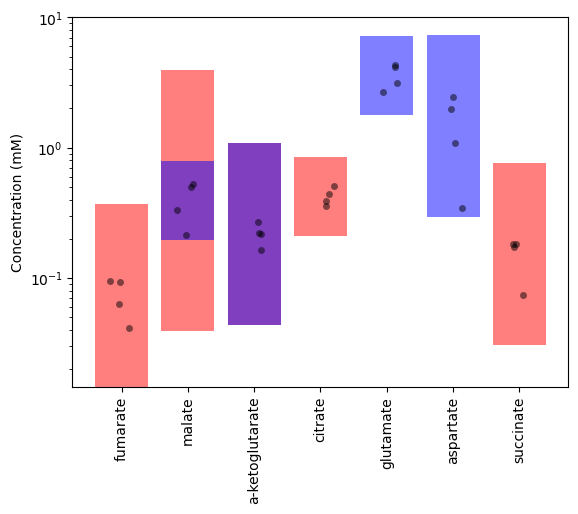

In [40]:

metabolite_mapping = [
    ('a-ketoglutarate', ('akg_m', 5.0)),
    ('a-ketoglutarate', ('akg_c', 5.0)),
    ('citrate', ('cit_m', 2.0)),
    ('fumarate', ('fum_m', 5.0)),
    #('lactate', ('lac_L_c', 5.0)),
    #('lactate', ('lac_L_m', 5.0)),
    ('malate', ('mal_L_m', 10.0)),
    ('malate', ('mal_L_c', 2.0)),
    #('pyruvate', ('pyr_m', 100.0)),
    #('pyruvate', ('pyr_c', 2.0)),
    ('succinate', ('succ_m',  5.0)),
    ('glutamate', ('glu_L_c', 2.0)), # Most glutatmate is in the cytosol D.S. paper
    ('aspartate', ('asp_L_c', 5.0)),
]

metabolites_to_map = list(set(m[0] for m in metabolite_mapping))
data_extracted = tissue_metabolomics[tissue_samples][metabolites_to_map] * 1e-3 # convert uM to mM 

# Plot the metabolomics data and the assumed bounds for the metabolites
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
# Plot all the data points 
sns.stripplot(data=data_extracted, ax=ax, jitter=0.2, color='black', alpha=0.5)

means = data_extracted.mean()

# Compute mitochondrial and cytosolic ranges -> mean/scaling , mean*scaling
ranges = []
for met, (met_id, scaling) in metabolite_mapping:
    mid = means[met]
    lb = mid / scaling
    ub = mid * scaling
    if met_id.endswith('_m'):
        ranges.append({'metabolite': met, 'lb': lb, 'ub': ub, 'compartment': 'mitochondrial'})
    else:
        ranges.append({'metabolite': met, 'lb': lb, 'ub': ub, 'compartment': 'cytosolic'})

ranges = pd.DataFrame(ranges)

# Plot the mitochondiral and cytosolic ranges as ractangles between lb and ub 
ranges = ranges.set_index('metabolite')
mit_ranges = ranges[ranges.compartment == 'mitochondrial']
cyt_ranges = ranges[ranges.compartment == 'cytosolic']

plt.bar(mit_ranges.index, mit_ranges.ub - mit_ranges.lb, bottom=mit_ranges.lb, color='red', alpha=0.5)
plt.bar(cyt_ranges.index, cyt_ranges.ub - cyt_ranges.lb, bottom=cyt_ranges.lb, color='blue', alpha=0.5)

plt.yscale('log')

plt.xticks(rotation=90)

plt.ylabel('Concentration (mM)')

plt.show()

In [41]:
# # # Map the metabolomics data to the model
for metabolite_name, (metabolite_id, uncertainty_fac) in metabolite_mapping:
    concentration = data_extracted[metabolite_name].mean()
    uncertainty = data_extracted[metabolite_name].std()
    #print(f"{metabolite_name} concentration: {concentration} +/- {uncertainty*uncertainty_fac}")
    uncertainty = (concentration / uncertainty_fac, concentration * uncertainty_fac)
    set_concentration(reduced_model, metabolite_id, concentration, uncertainty=uncertainty)
    
# Run the optimization again
sol = reduced_model.optimize()

In [42]:
# Carnitine concentration in Muscle 500 pmol/mg -> (1000g/L density of muscle) -> 500 uM
carnitine_concentration = 500e-3
set_concentration(reduced_model, 'crn_c', carnitine_concentration, 0.9)
#set_concentration(reduced_model, 'crn_m', carnitine_concentration, 0.9)

# Long chain acyl-carnitine concentration 01 - 10 uM in Muscle 
# https://www.nature.com/articles/s41598-017-17797-x
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4274800/
set_concentration(reduced_model, 'pmtcrn_c', 2e-3 , 0.1)
set_concentration(reduced_model, 'pmtcrn_m', 1e-3 , 0.1)

# acyl-CoA in Muscle
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4274800/
set_concentration(reduced_model, 'pmtcoa_c', 0.1e-3 , 0.5)
set_concentration(reduced_model, 'pmtcoa_m', 0.1e-3 , 0.5)

# CoA in Muscle
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4274800/
#set_concentration(reduced_model, 'coa_m', 10e-3 , 0.9)
set_concentration(reduced_model, 'coa_c', 10e-3 , 0.9)


# Succinyl-CoA in Muscle - REF?
set_concentration(reduced_model, 'succoa_m', 10e-3 , 0.5)

# Acetyl-CoA in Muscle - REF?
set_concentration(reduced_model, 'accoa_m', 20e-3 , 0.5)

# Aceteoacetyl-CoA in Muscle - REF?
set_concentration(reduced_model, 'aacoa_m', 1e-3 , 0.9)


# Try glycerol-3 phosphate integration (assumed to be quite abundand in muscle)
# https://www.nature.com/articles/s41387-018-0045-x -> 10 - 100 uM
set_concentration(reduced_model, 'glyc3p_c', 10e-3, 0.9)


# Mitochondiral pyruvate concentration arround 25 uM 
set_concentration(reduced_model, 'pyr_m', 25e-3, uncertainty=0.9)
set_concentration(reduced_model, 'pyr_c', 50e-3, uncertainty=0.9)


# Constraint lactate transport to be close to equilibirium
reduced_model.delta_g.L_LACt2r.variable.ub = 0.1 # kcal/mol
reduced_model.delta_g.L_LACt2r.variable.lb = -0.1 # kcal/mol

# Constraint mitochondiral pyruvate transport
reduced_model.delta_g.PYRt2m.variable.ub = 2.0 # kcal/mol
reduced_model.delta_g.PYRt2m.variable.lb = -2.0 # kcal/mol


sol = reduced_model.optimize()
print(sol.objective_value)

6.514446666666667


In [43]:
TVA = variability_analysis(reduced_model, kind=DeltaG)

# Transform from log to log10 -> scale with log10(e)
TVA['minimum'] = TVA.minimum * np.log10(np.exp(1))
TVA['maximum'] = TVA.maximum * np.log10(np.exp(1))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

# Print a list of delta G with low range
for met_id in TVA.index:
    entry = TVA.loc[met_id]
    if abs(entry['minimum']) < 1e-3 and abs(entry['maximum']) < 1e-3:
        print(met_id, entry['minimum'], entry['mid'], entry['maximum'])
        print('-------------------')




2025-09-11 11:23:25,153 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 65/65 [00:00<00:00, 92.25it/s]


In [44]:
# Print malate aspartate shuttle free ene
aspartate_malate_shuttle= ['MDH', 'ASPTA', 'ASPTAm', 'MDHm', 'ASPGLUm', 'AKGMALtm']
lactate_shuttle = ['LDH_L', 'LDH_Lm', 'PYRt2m','L_LACDcm' ]

for rxn_id in aspartate_malate_shuttle:
    entry = TVA.loc["DG_"+rxn_id]
    rxn = reduced_model.reactions.get_by_id(rxn_id)
    print(rxn_id,rxn.reaction, entry['minimum'], entry['maximum'])
    print('-------------------')

MDH mal_L_c + nad_c <-- h_c + nadh_c + oaa_c 0.2171472409516259 3.520221657689939
-------------------
ASPTA akg_c + asp_L_c <=> glu_L_c + oaa_c -2.315489271720263 0.23110489725785077
-------------------
ASPTAm akg_m + asp_L_m <=> glu_L_m + oaa_m -2.82473588152492 1.3298994560496087
-------------------
MDHm mal_L_m + nad_m --> h_m + nadh_m + oaa_m -2.3695905169901006 4.5928381529272934e-15
-------------------
ASPGLUm asp_L_m + glu_L_c + h_c --> asp_L_c + glu_L_m + h_m -3.16062824349089 -1.3843601133587486
-------------------
AKGMALtm akg_m + mal_L_c <=> akg_c + mal_L_m -1.5974675476055606 0.7708899588944398
-------------------


In [45]:
# Here we choose a flux profile
reduced_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-0.028000,None
ACONTm,0.500668,None
AKGDm,0.500668,None
AKGMALtm,0.032300,None
ASPGLUm,0.032300,None
...,...,...
CYOOm2i,1.420338,None
cyt_atp2adp,6.514447,None
PiC,6.419780,None
proton_in,1.000000,None


In [46]:
# Assume the direaction of all three shuttles
reduced_model.reactions.G3PD1.bounds = (-2.0, -0.001)


# This is not the function associated with this transporter
# https://slc.bioparadigms.org/protein?GeneName=SLC25A10    
reduced_model.reactions.r0822.bounds = (0.0, 0.0)
reduced_model.reactions.atp2amp_c.bounds = (0.5,0.501)

sol = reduced_model.optimize()


In [47]:
# Run a flux analysis to see how constrain is the flux distribution
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')


2025-09-11 11:23:26,677 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 75/75 [00:00<00:00, 250.04it/s]


In [48]:
FVA

,minimum,maximum
ACACT1rm,-0.028000,-0.028000
ACONTm,0.500668,0.500668
AKGDm,0.500668,0.500668
AKGMALtm,0.001000,0.034700
ASPGLUm,0.001000,0.034700
...,...,...
CYOOm2i,1.420338,1.420338
cyt_atp2adp,5.460572,5.513697
PiC,6.367905,6.419030
proton_in,1.000000,1.100000


In [49]:
sol = reduced_model.optimize()

# Remove the reactions that cannot carry flux
EPSILON = 1e-9
reactions_to_remove = [r for r in reduced_model.reactions if FVA.loc[r.id, 'minimum'] >= -EPSILON and FVA.loc[r.id, 'maximum'] <= EPSILON ]
print(reactions_to_remove)
reduced_model.remove_reactions(reactions_to_remove)
reduced_model.repair()

sol = reduced_model.optimize()


metabolites_to_remove = [m for m in reduced_model.metabolites if len(m.reactions) == 0]
reduced_model.remove_metabolites(metabolites_to_remove)
reduced_model.repair()

sol = reduced_model.optimize()
print(sol.objective_value)

[<Reaction L_LACDcm at 0x7fb172efe850>, <Reaction r0822 at 0x7fb172efea60>, <Reaction FUM at 0x7fb172efed30>, <Reaction ACYP at 0x7fb172efef70>]
5.513696666666668


In [50]:
# Run a flux analysis to see how constrain is the flux 
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')

# Plot the fluxes as bars starting at min and ending at max
FVA['range'] = FVA.maximum - FVA.minimum
FVA['mid'] = (FVA.maximum + FVA.minimum) / 2

fasted_fluxes = FVA['mid']

2025-09-11 11:23:27,369 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 71/71 [00:00<00:00, 247.81it/s]


In [51]:
atp2adp_bounds = FVA.loc['cyt_atp2adp',['minimum', 'maximum']].values

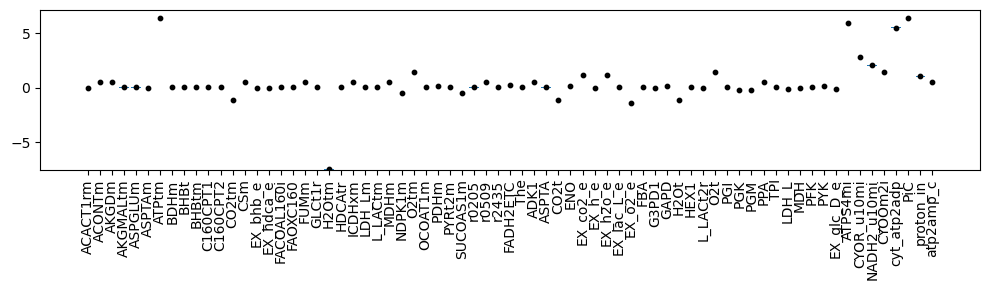

In [52]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

f = plt.figure(figsize=(10, 3))
plt.bar(FVA.index, FVA.range, bottom=FVA.minimum)
plt.scatter(FVA.index, FVA.mid, color='k', s=10)

# from cobra.flux_analysis.parsimonious import optimize_minimal_flux
# reduced_model.objective = reduced_model.problem.Objective(reduced_model.reactions.cyt_atp2adp.forward_variable, direction='max')
# sol = optimize_minimal_flux(reduced_model)
# plt.scatter(sol.fluxes.index, sol.fluxes, color='r', s=10)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [53]:
# Print bidreactional reactions from FVA
for r in reduced_model.reactions:
    if FVA.loc[r.id, 'minimum'] < -EPSILON and FVA.loc[r.id, 'maximum'] > EPSILON:
        print(r.id, r.reaction, FVA.loc[r.id, ['minimum', 'maximum']].values)


In [54]:
# Force minimal flux of 1e-4 and deltaG of -1e-4
EPSILON_DG = 0.01 # kcal/mol
EPSILON_FLUX = 0.005
sol = reduced_model.optimize()

for rxn in reduced_model.reactions:
    sol = reduced_model.optimize()
    primal_dg = None
    if FVA.loc[rxn.id].maximum > 0 and FVA.loc[rxn.id].minimum < EPSILON_FLUX:
        rxn.bounds = (EPSILON_FLUX, rxn.bounds[1])
        try:
            deltaG = reduced_model.delta_g.get_by_id(rxn.id).variable
            deltaG.ub = -EPSILON_DG
        except KeyError:
            pass
        
    elif FVA.loc[rxn.id].minimum < 0 and FVA.loc[rxn.id].maximum > -EPSILON_FLUX:
        rxn.bounds = (rxn.bounds[0], -EPSILON_FLUX)
        try:
            deltaG = reduced_model.delta_g.get_by_id(rxn.id).variable
            deltaG.lb = EPSILON_DG
        except KeyError:
            pass
    else:
        pass

    try:
        sol = reduced_model.optimize()
        if sol.status != 'optimal':
            raise SolverError(f"Failed to constrain {rxn.id} as {primal_dg}")
    except SolverError:
        raise SolverError(f"Failed to constrain {rxn.id} as {primal_dg}")
    


In [55]:
FVA.loc[rxn.id]


minimum    0.5000
maximum    0.5010
range      0.0010
mid        0.5005
Name: atp2amp_c, dtype: float64

2025-09-11 11:23:28,751 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 80/80 [00:00<00:00, 134.43it/s]


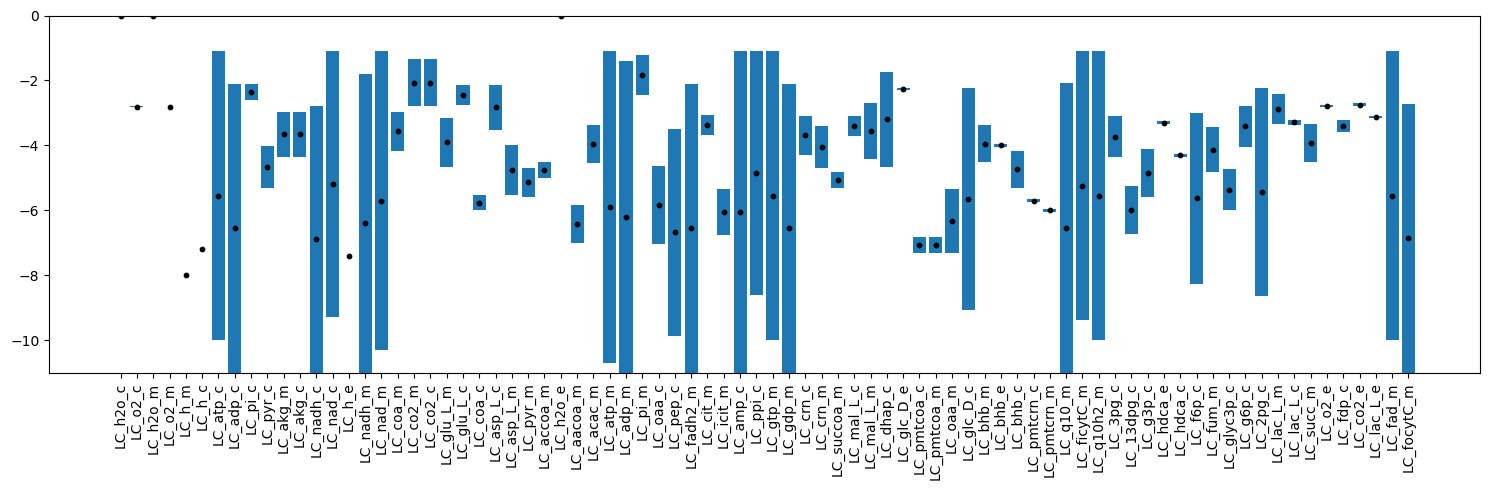

In [56]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Concentration of metabolites
from pytfa.optim.variables import LogConcentration
TVA = variability_analysis(reduced_model, kind=LogConcentration)


# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))

# Transform from log to log10 -> scale with log10(e)
TVA['minimum'] = TVA.minimum * np.log10(np.exp(1))
TVA['maximum'] = TVA.maximum * np.log10(np.exp(1))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2


plt.bar(TVA.index, TVA.range, bottom=TVA.minimum)
plt.scatter(TVA.index, TVA.mid, color='k', s=10)
plt.xticks(np.arange(len(TVA.index)), TVA.index, rotation=90)
plt.tight_layout()

plt.show()

In [57]:
from pytfa.analysis import  apply_reaction_variability,     \
                            apply_generic_variability,      \
                            apply_directionality

from pytfa.optim.variables import DeltaG,DeltaGstd,LogConcentration
# Fesiblitity analysis
solution = reduced_model.optimize()



# Strip model of integers variables
fixed_directionality_model = apply_directionality(reduced_model, solution)

# Constraint fluxes
FVA = variability_analysis(fixed_directionality_model, kind='reactions')
tight_model = apply_reaction_variability(fixed_directionality_model, FVA)

# TVA of the model
thermo_vars = [DeltaG,DeltaGstd,LogConcentration]
TVA = variability_analysis(tight_model, kind=thermo_vars)

tight_model = apply_generic_variability(tight_model  , TVA)
 

 # Make surethe atp bounds are integrated
tight_model.reactions.cyt_atp2adp.bounds = atp2adp_bounds

2025-09-11 11:23:30,019 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 71/71 [00:00<00:00, 618.10it/s]
2025-09-11 11:23:30,281 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 61/61 [00:00<00:00, 735.07it/s]
2025-09-11 11:23:30,459 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaGstd'>
maximizing: 100%|██████████| 61/61 [00:00<00:00, 812.12it/s]
2025-09-11 11:23:30,628 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 80/80 [00:00<00:00, 829.51it/s]


In [58]:
from pytfa.optim import strip_from_integer_variables
from pytfa.analysis import sample

continuous_model = strip_from_integer_variables(tight_model)
continuous_model.repair()


2025-09-11 11:23:30,988 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Is the cobra_model still integer ? False


In [59]:
# Run TVA again to see if the TVA is still valid
TVA = variability_analysis(continuous_model, kind=DeltaG)

TVA['minimum'] = TVA['minimum'].apply(lambda x: 0.01 if x > 0 and x < 0.01 else x )
TVA['maximum'] = TVA['maximum'].apply(lambda x: -0.01 if x < 0 and x > -0.01 else x )

# Apply TVA to the model
continuous_model = apply_generic_variability(continuous_model, TVA)
continuous_model.optimize()

2025-09-11 11:23:31,280 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 61/61 [00:00<00:00, 4735.64it/s]


,fluxes,reduced_costs
ACACT1rm,-0.028000,None
ACONTm,0.500668,None
AKGDm,0.500668,None
AKGMALtm,0.027300,None
ASPGLUm,0.027300,None
...,...,...
CYOOm2i,1.420338,None
cyt_atp2adp,5.510697,None
PiC,6.416030,None
proton_in,1.000000,None


In [60]:
 # Make surethe atp bounds are integrated
continuous_model.reactions.cyt_atp2adp.lower_bound  = atp2adp_bounds[0]
continuous_model.reactions.cyt_atp2adp.upper_bound  = atp2adp_bounds[1]

continuous_model.optimize()

continuous_model.reactions.cyt_atp2adp 

Reaction identifier,cyt_atp2adp
Name,
Memory address,0x07fb190b5ee80
Stoichiometry,atp_c + h2o_c --> adp_c + h_c + pi_c Adenosine Triphosphate + Water --> Adenosine Diphosphate + Proton + Orthophosphate
GPR,
Lower bound,5.4605716666666675
Upper bound,5.513696666666668


In [61]:
continuous_model.solver.configuration.tolerances.feasibility = 1e-9
continuous_model.solver.configuration.tolerances.optimality = 1e-9
continuous_model.solver.configuration.tolerances.integrality = 1e-9


In [62]:
# Gelta D constraints for glycolysis (Lehninger)
continuous_model.delta_g.HEX1.variable.ub = -20 * 0.239006
continuous_model.delta_g.HEX1.variable.lb = -33.4 * 0.239006

# Make sure PYK is fwd driven
continuous_model.delta_g.PYK.variable.ub = -10 * 0.239006
continuous_model.delta_g.PYK.variable.lb = -30 * 0.239006

# PFK 
continuous_model.delta_g.PFK.variable.ub = -10 * 0.239006
continuous_model.delta_g.PFK.variable.lb = -25 * 0.239006

# FBA
continuous_model.delta_g.FBA.variable.lb = -10 * 0.239006 
continuous_model.delta_g.FBA.variable.ub = -6 * 0.239006 

continuous_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-0.028000,None
ACONTm,0.500668,None
AKGDm,0.500668,None
AKGMALtm,0.027300,None
ASPGLUm,0.027300,None
...,...,...
CYOOm2i,1.420338,None
cyt_atp2adp,5.510697,None
PiC,6.416030,None
proton_in,1.000000,None


In [63]:
# Rest of glycolysis close to equilibrium
continuous_model.delta_g.PGI.variable.lb = -0.5 * 0.239006 # Shu be very close to equilibrium
continuous_model.delta_g.TPI.variable.lb = -0.5 * 0.239006 # Shu be very close to equilibrium
continuous_model.delta_g.PGM.variable.ub = 0.5 * 0.239006 # reverse annotated

# PGK need to be somewhat forward driven 
continuous_model.delta_g.PGK.variable.ub = 0.5 * 0.239006 # reverse annotated

# GAPD -2 to 2 kcal 
continuous_model.delta_g.GAPD.variable.ub = -2.0 * 0.239006
continuous_model.delta_g.GAPD.variable.lb = -4.0 * 0.239006

# Enolase somewhat forward drive
continuous_model.delta_g.ENO.variable.lb = -0.5* 0.239006

sol = continuous_model.optimize()

In [64]:
# Lmimit ADK to be close to equilibrium
continuous_model.delta_g.ADK1.variable.lb = -0.1
sol = continuous_model.optimize()

In [65]:
# Other considerations
# PDHm is thought to be displaced from equilibrium
continuous_model.delta_g.PDHm.variable.ub = -1.0 # kcal/mol

# SCCOAS is not regulated -> close to equilibrium
continuous_model.delta_g.SUCOAS1m.variable.ub = 0.1 # kcal/mol

# AConitase close to equilibrium
continuous_model.delta_g.ACONTm.variable.lb = -0.1 # kcal/mol
# ICDHm close to equilibrium
continuous_model.delta_g.ICDHxm.variable.lb = -0.5 # kcal/mol

# NDPK1m close to equilibrium (GTP/ATP interconversion)
continuous_model.delta_g.NDPK1m.variable.ub = 0.1 # kcal/mol


# FUMm at equilibrium
continuous_model.delta_g.FUMm.variable.lb = -0.1 # kcal/mol

# Forward driven 3HB metabolism
continuous_model.delta_g.ACACT1rm.variable.ub = 4
# 
# Cloose to equilibrium
continuous_model.delta_g.BDHm.variable.lb = -0.1 # kcal/mol
# BHB Trasnport
continuous_model.delta_g.BHBt.variable.lb = -0.1 # kcal/mol 
# BHB transport in mitochondria
continuous_model.delta_g.BHBtm.variable.lb = -0.1 # kcal/mol
# coa transferasse 
continuous_model.delta_g.OCOAT1m.variable.lb = -1.0 # kcal/mol

sol = continuous_model.optimize()

In [66]:
# # Fatty acid transport into the mitochondria
continuous_model.delta_g.C160CPT1.variable.ub = -0.1 # kcal/mol
continuous_model.delta_g.C160CPT1.variable.lb = -0.5 # kcal/mol
sol = continuous_model.optimize()

continuous_model.delta_g.C160CPT2.variable.lb = -0.5 # kcal/mol
sol = continuous_model.optimize()


In [67]:
# Lactate dehydrogenases are forward driven
continuous_model.delta_g.LDH_L.variable.lb = 0.5 # kcal/mol
continuous_model.delta_g.LDH_L.variable.lb = 1.0 # kcal/mol
continuous_model.delta_g.LDH_Lm.variable.ub = -0.5 # kcal/mol

sol = continuous_model.optimize()

In [68]:
# Thermodynamic design principles of the malate-aspartate shuttle
# MDH in cytosol is backward driven
continuous_model.delta_g.MDH.variable.ub = 0.5
# The malate-alpha-ketoglutarate transporter CANNOT be forward driven
continuous_model.delta_g.AKGMALtm.variable.lb = -0.1# kcal/mol

# Transaminases should be close to equilibrium
continuous_model.delta_g.ASPTA.variable.lb = -0.1 # kcal/mol
continuous_model.delta_g.ASPTAm.variable.ub = 0.1 # kcal/mol
sol = continuous_model.optimize()

In [69]:
# ELECTRON TRANSPORT CHAIN - THE ETC is thermodynamically controled -> close to equilibrium
continuous_model.delta_g.NADH2_u10mi.variable.lb = -0.1 # kcal/mol
continuous_model.delta_g.CYOR_u10mi.variable.lb = -0.1# kcal/mol
continuous_model.delta_g.CYOOm2i.variable.lb = -1.0 # kcal/mol

# Min displacement 
continuous_model.delta_g.NADH2_u10mi.variable.ub = -0.01 # kcal/mol
continuous_model.delta_g.CYOR_u10mi.variable.ub = -0.01 # kcal/mol
continuous_model.delta_g.CYOOm2i.variable.ub = -0.01 # kcal/mol

sol = continuous_model.optimize()

In [70]:
# Constraint ATP synthase limit forward displacement
continuous_model.delta_g.ATPS4mi.variable.ub = -1.0 # kcal/mol
# sol = continuous_model.optimize()

In [71]:
# Constraint phosphate transport forward displacement
continuous_model.delta_g.PiC.variable.ub = -1.0 # kcal/mol
sol = continuous_model.optimize()

In [72]:
continuous_model.delta_g.r2435.variable.lb = -0.1 # kcal/mol
sol = continuous_model.optimize()

In [73]:
# Oxygen transport is fast - close to equilibrium
continuous_model.delta_g.O2t.variable.lb = -0.1 # kcal/mol
continuous_model.delta_g.O2tm.variable.lb = -0.1 # kcal/mol
sol = continuous_model.optimize()

In [74]:
continuous_model.delta_g.The.variable.lb = -0.1 # kcal/mol
sol = continuous_model.optimize()

In [75]:
# Make some assumption on the most importat 

# NAD concentration
nad_concentration = 1 # mM ~ 1 + 0.5 -> See DS paper
set_concentration(continuous_model, 'nad_c', nad_concentration, uncertainty=0.5)
set_concentration(continuous_model, 'nad_m', nad_concentration, uncertainty=0.5)

# Assumption of OAA 1-10 uM rangge
set_concentration(continuous_model, 'oaa_m', 1e-3, 0.5)
set_concentration(continuous_model, 'oaa_c', 2e-3, 0.5)

# FAD concentration should be similar to NAD concentration
fad_concentration = 1.0 # mM 
set_concentration(continuous_model, 'fad_m', fad_concentration, uncertainty=0.5)


# GDP concentration
gdp_concentration = 0.05 # mM
set_concentration(continuous_model, 'gtp_m', gdp_concentration, uncertainty=0.5)

# ATP concentration 5 mM range
set_concentration(continuous_model, 'atp_c', 2.0, uncertainty=0.1)

# Mitochondiral ATP concentration 
set_concentration(continuous_model, 'atp_m', 2.0, uncertainty=0.1)

# AMP concentration 1 uM range
set_concentration(continuous_model, 'amp_c', 1e-3, uncertainty=0.2)


# Ubiqionone 40 uM range  https://www.nature.com/articles/pr2015124
set_concentration(continuous_model, 'q10_m' , 40e-3, uncertainty=0.1)

# Ferrocyto-chrome c 100 uM range
set_concentration(continuous_model, 'ficytC_m', 100e-3, uncertainty=0.5)

# Diphotphate 0.1 mM ?!
set_concentration(continuous_model, 'ppi_c', 0.1, 0.9)

# Intra cellular glucose should be lowish 1-10 uM
set_concentration(continuous_model, 'glc_D_c',  10e-3, 0.99)

# mitochondiral co2 abour 2 fold hiher than extracellular + gradient
set_concentration(continuous_model, 'co2_m', 1.5 * co2_concentration, 0.1)
set_concentration(continuous_model, 'co2_c', 1.25 * co2_concentration, 0.1)

# Lower glycolytic intermediates 10uM
set_concentration(continuous_model, '3pg_c', 50e-3, 0.99)



In [76]:
TVA = variability_analysis(continuous_model, kind=LogConcentration)


2025-09-11 11:23:31,548 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 80/80 [00:00<00:00, 4701.41it/s]


In [77]:
# Sample the concnetrations and fluxes in the continuous_model
sampling = sample(continuous_model, 1000, processes=4, seed=0,  method='optgp', thinning=1000)

2025-09-11 11:23:31,681 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2025-09-11 11:23:32,188 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2025-09-11 11:23:32,623 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm
2025-09-11 11:23:32,623 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm_reverse_3c90a
2025-09-11 11:23:32,624 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm
2025-09-11 11:23:32,624 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm_reverse_8079b
2025-09-11 11:23:32,624 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm
2025-09-11 11:23:32,625 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm_reverse_ec8eb


2025-09-11 11:23:53,588 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 80/80 [00:00<00:00, 4275.54it/s]


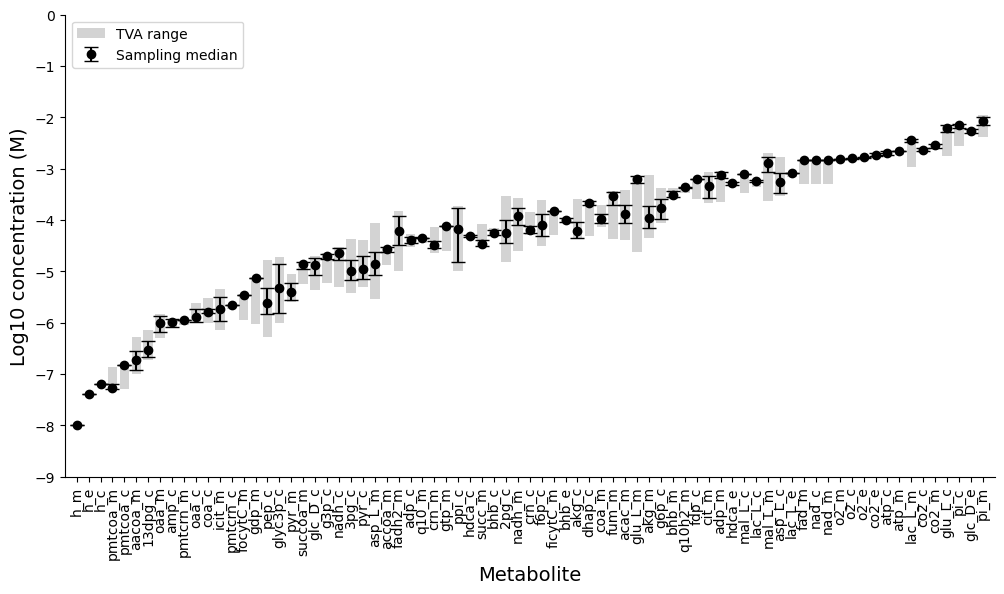

In [78]:
TVA = variability_analysis(continuous_model, kind=LogConcentration)

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(12, 6))

# Convert from ln to log10
TVA['minimum'] = np.log10(np.exp(TVA.minimum))
TVA['maximum'] = np.log10(np.exp(TVA.maximum))
sampling_log10 = np.log10(np.exp(sampling))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

# TVA sort by range
TVA = TVA.sort_values('mid', ascending=True)
# Drop the last 3 values 
TVA = TVA[:-3]

LC_MEDIAN = sampling_log10.median()[TVA.index]
LC_UQ = sampling_log10.quantile(0.95)[TVA.index]
LC_LQ = sampling_log10.quantile(0.05)[TVA.index]


plt.bar(TVA.index, TVA.range, bottom=TVA.minimum, color='lightgray')
plt.errorbar( TVA.index, LC_MEDIAN,yerr=[LC_MEDIAN - LC_LQ, LC_UQ - LC_MEDIAN], fmt='o', color='k', ecolor='k', capsize=5)
# Align the xticks with the metabolites names
# Get metablites names from model 
metabolite_names = [reduced_model.metabolites.get_by_id(met_id[3:]).id for met_id in TVA.index]
plt.xticks(np.arange(0,len(TVA.index)),  metabolite_names, rotation=90)

plt.xlim(-1, len(TVA.index))
sns.despine()

plt.ylim(-9,0)

plt.legend(['TVA range', 'Sampling median', 'Sampling 95% CI'], loc='upper left')

plt.ylabel('Log10 concentration (M)', fontsize=14)
plt.xlabel('Metabolite', fontsize=14)

plt.savefig('output/continuous_model_concentration_TVA.svg', bbox_inches='tight',)



In [79]:
# Write concentration min, max and median and 95% CI to a csv file in mM
# Debug: check for NaN or inf values and shape mismatches
metabolite_names = [reduced_model.metabolites.get_by_id(met_id[3:]).id for met_id in TVA.index]
concentration_df = pd.DataFrame({
    'metabolite': metabolite_names,
    'min_mM': 10 ** (TVA.minimum.values + 3),
    'max_mM': 10 ** (TVA.maximum.values + 3),
    'median_mM': 10 ** (LC_MEDIAN.values + 3),
    'lq_mM': 10 ** (LC_LQ.values + 3),
    'uq_mM': 10 ** (LC_UQ.values + 3),
})


concentration_df.to_csv('output/continuous_model_concentration_TVA_mM.csv', index=False)

In [80]:
TVA.loc[['LC_bhb_e', 'LC_bhb_c', 'LC_bhb_m']]

,minimum,maximum,range,mid
LC_bhb_e,-4.045757,-3.958607,0.087150,-4.002182
LC_bhb_c,-4.318958,-4.165794,0.153165,-4.242376
LC_bhb_m,-3.592645,-3.373465,0.219179,-3.483055


2025-09-11 11:23:54,254 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 61/61 [00:00<00:00, 3882.91it/s]


(-10.0, 10.0)

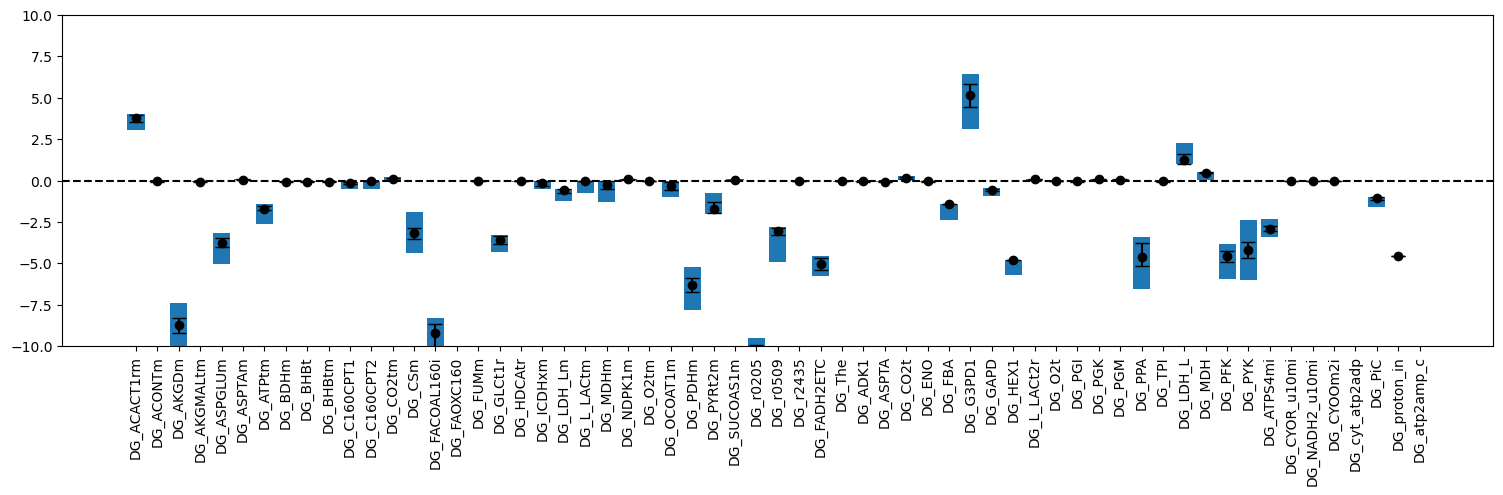

In [81]:
from pytfa.optim.variables import DeltaG
# PLot the TVA of the reaction deltaG
TVA = variability_analysis(continuous_model, kind=DeltaG)

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

plt.bar(TVA.index, TVA.range, bottom=TVA.minimum)

LC_MEDIAN = sampling.median()[TVA.index]
LC_UQ = sampling.quantile(0.95)[TVA.index]
LC_LQ = sampling.quantile(0.05)[TVA.index]

plt.errorbar(TVA.index, LC_MEDIAN, yerr=[LC_MEDIAN - LC_LQ, LC_UQ - LC_MEDIAN], fmt='o', color='k', ecolor='k', capsize=5)

# Plot the 0 line 
plt.axhline(0, color='k', linestyle='--')

plt.xticks(np.arange(0,len(TVA.index)),  TVA.index, rotation=90)
plt.tight_layout()


plt.ylim(-10, 10)


In [82]:
# Print malate aspartate shuttle free ene
aspartate_malate_shuttle= ['MDH', 'ASPTA', 'ASPTAm', 'MDHm', 'ASPGLUm', 'AKGMALtm']

for rxn_id in aspartate_malate_shuttle:
    entry = TVA.loc["DG_"+rxn_id]
    rxn = reduced_model.reactions.get_by_id(rxn_id)
    print(rxn_id,rxn.reaction, entry['minimum'], entry['maximum'])
    print('-------------------')

MDH mal_L_c + nad_c <-- h_c + nadh_c + oaa_c 0.01 0.5
-------------------
ASPTA akg_c + asp_L_c --> glu_L_c + oaa_c -0.1 -0.01
-------------------
ASPTAm akg_m + asp_L_m <-- glu_L_m + oaa_m 0.01 0.1
-------------------
MDHm mal_L_m + nad_m --> h_m + nadh_m + oaa_m -1.2820758836185417 -0.01
-------------------
ASPGLUm asp_L_m + glu_L_c + h_c --> asp_L_c + glu_L_m + h_m -5.033608638287945 -3.1876049609474926
-------------------
AKGMALtm akg_m + mal_L_c --> akg_c + mal_L_m -0.1 -0.01
-------------------


In [83]:
# Check minimal displacement of the reactions
for rxn_id in TVA.index:
    entry = TVA.loc[rxn_id]
    if abs(entry['minimum']) < 1e-2 or abs(entry['maximum']) < 1e-2:
        print(rxn_id, entry['minimum'],  entry['maximum'])
        print('-------------------')

In [84]:
(sampling['DG_FAOXC160']/8.0).mean()

-8.467681471664827

2025-09-11 11:31:54,111 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reaction
maximizing: 100%|██████████| 71/71 [00:00<00:00, 2612.49it/s]


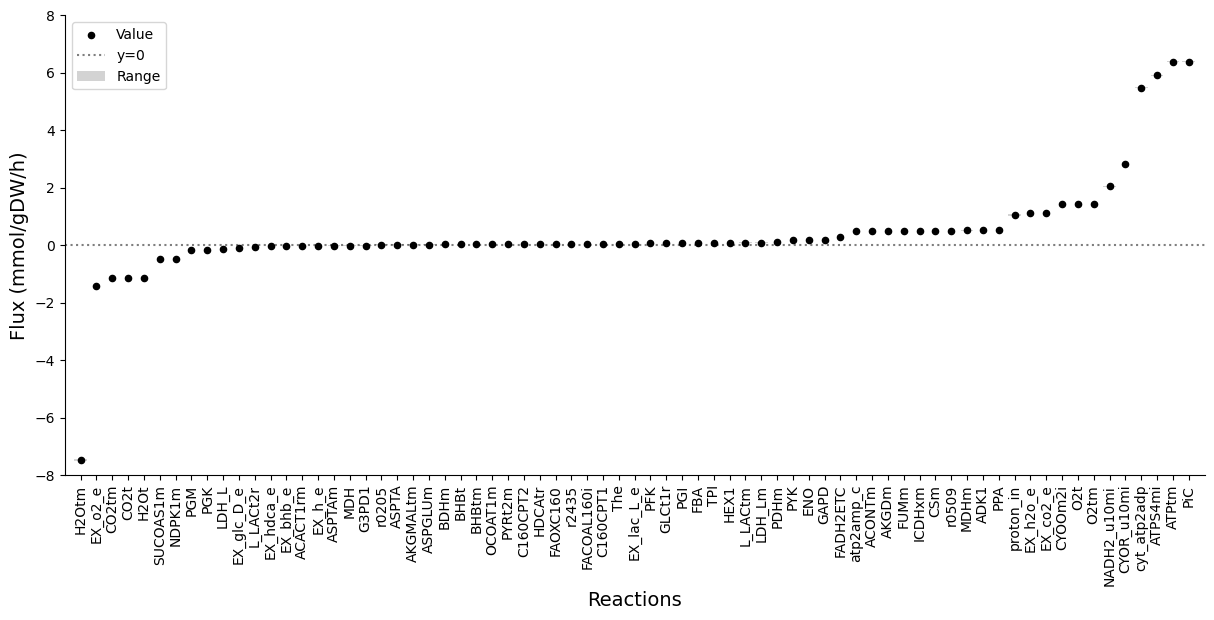

In [107]:
from pytfa.optim.variables import DeltaG
# PLot the TVA of the reaction fluxes
TVA = variability_analysis(continuous_model, kind='reaction')

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(12, 6))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

# Sort TVA by mid 
TVA = TVA.sort_values('mid', ascending=True)

plt.bar(TVA.index, TVA.range, bottom=TVA.minimum, color='lightgray')
plt.scatter(TVA.index, TVA.mid, color='k', s=20)

# Compute net fluxes from sampling even entries forward odd entries backward
# until length of fluxes
fluxes = sampling.iloc[:,:-1:2] - sampling.iloc[:,1::2].values


LC_MEDIAN = fluxes.median()[TVA.index]
LC_UQ = fluxes.quantile(0.95)[TVA.index]
LC_LQ = fluxes.quantile(0.05)[TVA.index]

#plt.errorbar(TVA.index, LC_MEDIAN, yerr=[LC_MEDIAN - LC_LQ, LC_UQ - LC_MEDIAN], fmt='o', color='k', ecolor='k', capsize=5)

# Plot the 0 line 
plt.axhline(0, color='k', linestyle=':', alpha = 0.5)
plt.legend(['Value', 'y=0', 'Range', ], loc='upper left')

plt.xticks(np.arange(0,len(TVA.index)),  TVA.index, rotation=90)
plt.tight_layout()
sns.despine()

plt.ylim(-8, 8)
plt.xlim(-1, len(TVA.index))
plt.ylabel('Flux (mmol/gDW/h)', fontsize=14)
plt.xlabel('Reactions', fontsize=14)

plt.savefig('./output/fluxes.svg', bbox_inches='tight')



In [114]:
# Write fluxes min, max and median and 95% CI to a csv file in mumol/min/gBW
# Debug: check for NaN or inf values and shape mismatches
flux_df = pd.DataFrame({
    'reaction': TVA.index,
    'reaction name': [continuous_model.reactions.get_by_id(rxn_id).name for rxn_id in TVA.index],
    'min_mumol_per_min_per_gBW': TVA.minimum.values,
    'max_mumol_per_min_per_gBW': TVA.maximum.values,
    'median_mumol_per_min_per_gBW': LC_MEDIAN.values,
    'lq_mumol_per_min_per_gBW': LC_LQ.values,
    'uq_mumol_per_min_per_gBW': LC_UQ.values,
})

flux_df.to_csv('output/continuous_model_fluxes_mumol_per_min_per_gBW.csv', index=False)

In [113]:
flux_df

,reaction,reaction name,min_mumol_per_min_per_gBW,max_mumol_per_min_per_gBW,median_mumol_per_min_per_gBW,lq_mumol_per_min_per_gBW,uq_mumol_per_min_per_gBW
0,H2Otm,"H2O Transport, Mitochondrial",-7.505034,-7.459909,-7.486654,-7.498266,-7.473233
1,EX_o2_e,Exchange of Oxugen,-1.420338,-1.420338,-1.420338,-1.420338,-1.420338
2,CO2tm,"CO2 Transport _Diffusion, Mitochondrial",-1.128670,-1.128670,-1.128670,-1.128670,-1.128670
3,CO2t,CO2 Transporter via Diffusion,-1.128670,-1.128670,-1.128670,-1.128670,-1.128670
4,H2Ot,H2O Transport via Diffusion,-1.128670,-1.128670,-1.128670,-1.128670,-1.128670
...,...,...,...,...,...,...,...
66,CYOR_u10mi,CYOR_u10mi,2.840676,2.840676,2.840676,2.840676,2.840676
67,cyt_atp2adp,,5.463572,5.510697,5.491225,5.477501,5.502873
68,ATPS4mi,ATP synthase _four protons for one ATP,5.898237,5.943362,5.924982,5.911562,5.936595
69,ATPtm,"ADP/ATP Transporter, Mitochondrial",6.370905,6.416030,6.397650,6.384230,6.409263


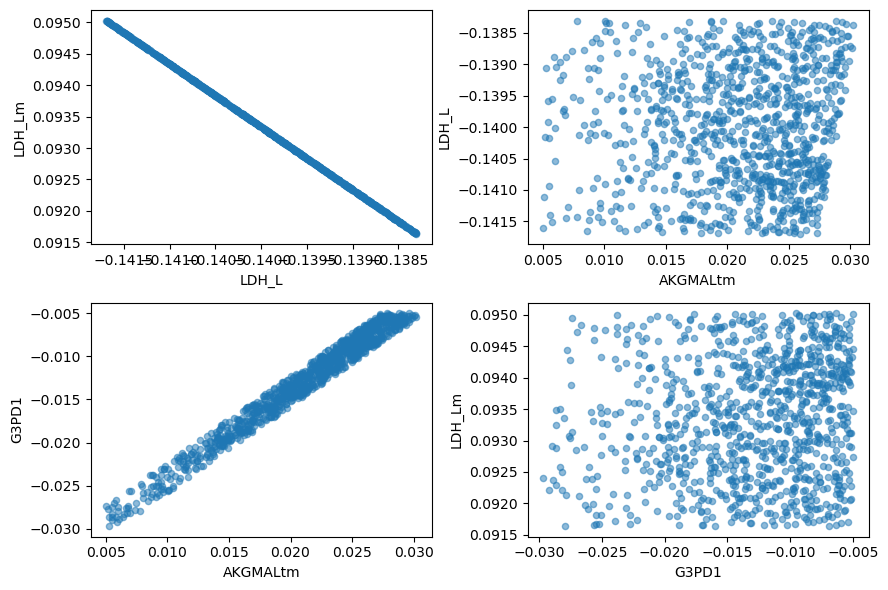

In [87]:
f, ax = plt.subplots(2,2, figsize=(9,6))

fluxes = sampling.iloc[:, 0:2*len(continuous_model.reactions):2] - sampling.iloc[:, 1:2*len(continuous_model.reactions)+1:2].values


fluxes.plot.scatter('LDH_L', 'LDH_Lm', alpha=0.5, ax =ax[0,0])
fluxes.plot.scatter('AKGMALtm', 'LDH_L', alpha=0.5, ax =ax[0,1])
fluxes.plot.scatter('AKGMALtm','G3PD1',  alpha=0.5, ax =ax[1,0])
fluxes.plot.scatter('G3PD1', 'LDH_Lm', alpha=0.5, ax =ax[1,1])



# for a in ax.flatten():
#     a.set_xlim(0,0.2)
#     a.set_ylim(0,0.2)

FVA.loc['PYRt2m']
plt.tight_layout()

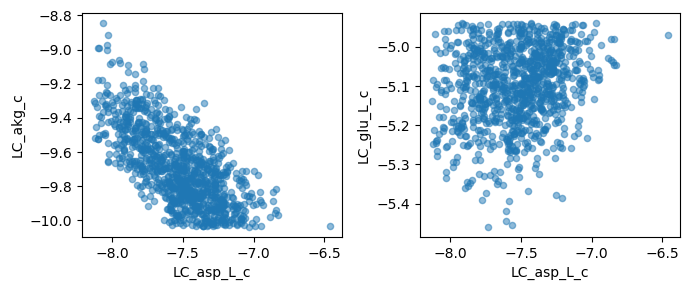

In [88]:
#Scatter for LC_pmtcoa_c and LC_pmtcoa_m
f, ax = plt.subplots(1,2, figsize=(7,3))

sampling.plot.scatter('LC_asp_L_c', 'LC_akg_c', alpha=0.5, ax =ax[0])
sampling.plot.scatter('LC_asp_L_c', 'LC_glu_L_c', alpha=0.5, ax =ax[1]) 

plt.tight_layout()
plt.show()

In [89]:
# Mtochondital charge balance 
charge_transport = {
    'CYOOm2i': -4.0,
    'CYOR_u10mi': -4.0,
    'NADH2_u10mi': -4.0,
    'ATPS4mi': 3.0,
    'ASPGLUm': 1.0,
    'ATPtm': 1.0,
    'proton_in': 1.0,
}


sampling['charge_balance'] = 0
for rxn_id, charge in charge_transport.items():
    print(rxn_id, charge , sampling[rxn_id].median())
    sampling['charge_balance'] += sampling[rxn_id] * charge

sampling['charge_balance'] = sampling['charge_balance'] * 1.2

CYOOm2i -4.0 1.4203381249999945
CYOR_u10mi -4.0 2.840676249999989
NADH2_u10mi -4.0 2.0503385059692008
ATPS4mi 3.0 5.9249820919595635
ASPGLUm 1.0 0.02214125308570008
ATPtm 1.0 6.39765042529298
proton_in 1.0 1.0485633813756523


<Axes: ylabel='Frequency'>

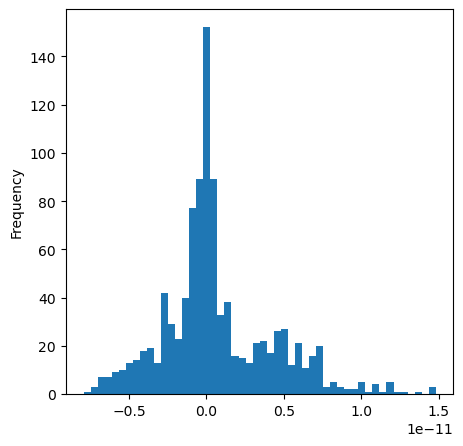

In [90]:
# Plor the charge balance
plt.figure(figsize=(5, 5))
sampling['charge_balance'].plot.hist(bins=50)

In [91]:
# # Make alist of all turn over rates that are conistantly low < 4.0 
# # exclude h2o and na1
# low_turnover = [m for m in turnover.columns[(turnover.abs().mean() < .1)] if not m.endswith("_e")] 

# # Plot the turnover rates as a boxplot
# f, ax = plt.subplots(figsize=(8, 5))
# sns.boxplot(data=turnover[low_turnover], ax=ax)
# plt.xticks(rotation=90)
# plt.show()

In [92]:
# Print all reaction with a deltaG_std  > +/- 10 kcal/mol
for rxn in continuous_model.reactions:
    if rxn.thermo['deltaGR'] > 5 and not rxn in continuous_model.boundary:
        print(rxn.id, rxn.reaction, rxn.thermo)

ACACT1rm 2.0 accoa_m <-- aacoa_m + coa_m {'isTrans': False, 'computed': True, 'deltaGR': 7.0560000000002105, 'deltaGRerr': 1.087366929789572}
ADK1 amp_c + atp_c + h_c --> 2.0 adp_c {'isTrans': False, 'computed': True, 'deltaGR': 10.24962080568946, 'deltaGRerr': 2}
FBA fdp_c --> dhap_c + g3p_c {'isTrans': False, 'computed': True, 'deltaGR': 5.604831372302954, 'deltaGRerr': 1.231339855604455}
PYK adp_c + h_c + pep_c --> atp_c + pyr_c {'isTrans': False, 'computed': True, 'deltaGR': 5.609472160844774, 'deltaGRerr': 0.654304974763298}
CYOR_u10mi 2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_c + q10_m {'isTrans': True, 'computed': True, 'deltaGR': 6.5556627684669095, 'deltaGrxn': -11.643612983011053, 'deltaGRerr': 2.9916129428788074}
NADH2_u10mi 5.0 h_m + nadh_m + q10_m --> 4.0 h_c + nad_m + q10h2_m {'isTrans': True, 'computed': True, 'deltaGR': 22.84204887623445, 'deltaGrxn': -4.456864750982504, 'deltaGRerr': 3.07450548869245}


In [93]:
# Print all reactions that use amp_c
for rxn in continuous_model.reactions:
    if 'amp_c' in [m.id for m in rxn.metabolites]:
        print(rxn.id, rxn.reaction, rxn.thermo)

FACOAL160i atp_c + coa_c + hdca_c --> amp_c + h_c + pmtcoa_c + ppi_c {'isTrans': False, 'computed': True, 'deltaGR': -21.838258329698704, 'deltaGRerr': 1.2316793413871974}
ADK1 amp_c + atp_c + h_c --> 2.0 adp_c {'isTrans': False, 'computed': True, 'deltaGR': 10.24962080568946, 'deltaGRerr': 2}
atp2amp_c atp_c + h2o_c --> amp_c + 2 h_c + ppi_c {'isTrans': False, 'computed': True, 'deltaGR': -28.216344189621168, 'deltaGRerr': 0.7480213900684927}


In [94]:
1/0

ZeroDivisionError: division by zero

In [ ]:
# Write the samples to a csv file
# NOTE NOT TO OVERWRITE THE ORIGINAL FILE
sampling.to_csv( redgem_file_name.replace('.json','_tfa_sampling.csv'), index=False)


In [ ]:
# Save the continuous model
from pytfa.io.json import save_json_model
save_json_model(continuous_model, redgem_file_name.replace('.json', '_continuous.json'))